# Test für verbessertes Modell (v2)

Testet das verbesserte Modell mit allen neuen Features

In [6]:
import joblib
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Lade v2 Modell
model_v2 = joblib.load('../best_house_model_v2.pkl')

print("✓ Modell v2 geladen")

✓ Modell v2 geladen


## Helper-Funktion: Feature Engineering für v2

In [7]:
def prepare_data_v2(data):
    """
    Wendet ALLE neuen Features auf Test-Daten an
    """
    df = data.copy()
    
    # Basis Features
    df['rooms_per_household'] = df['total_rooms'] / df['households']
    df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
    df['population_per_household'] = df['population'] / df['households']
    
    # Polynomiale Features
    df['median_income_squared'] = df['median_income'] ** 2
    df['median_income_cubed'] = df['median_income'] ** 3
    
    # Interaktionen
    df['income_per_room'] = df['median_income'] / (df['total_rooms'] + 1)
    df['income_per_person'] = df['median_income'] / (df['population'] + 1)
    df['lat_long'] = df['latitude'] * df['longitude']
    df['income_times_age'] = df['median_income'] * df['housing_median_age']
    
    # Log-Transformationen
    df['log_total_rooms'] = np.log1p(df['total_rooms'])
    df['log_population'] = np.log1p(df['population'])
    df['log_median_income'] = np.log1p(df['median_income'])
    
    # NEUE: Distanzen zu mehreren Städten
    cities = {
        'sf': (37.77, -122.41),
        'la': (34.05, -118.24),
        'san_diego': (32.72, -117.16),
        'sacramento': (38.58, -121.49)
    }
    
    for city_name, (lat, lon) in cities.items():
        df[f'distance_to_{city_name}'] = np.sqrt(
            (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        )
    
    # NEUE: Minimale Distanz zu wichtigen Städten
    distance_cols = [f'distance_to_{city}' for city in cities.keys()]
    df['min_distance_to_city'] = df[distance_cols].min(axis=1)
    
    # NEUE: Küstennähe
    df['is_coastal'] = df['ocean_proximity'].isin(['NEAR BAY', 'NEAR OCEAN', '<1H OCEAN']).astype(int)
    
    # NEUE: Dichte-Features
    df['rooms_per_person'] = df['total_rooms'] / (df['population'] + 1)
    df['bedrooms_per_household'] = df['total_bedrooms'] / df['households']
    
    # Binning (Platzhalter - in echtem Modell würde man die Bins vom Training wiederverwenden)
    df['lat_bin'] = pd.cut(df['latitude'], bins=10, labels=False)
    df['long_bin'] = pd.cut(df['longitude'], bins=10, labels=False)
    
    # Geo-Cluster (Platzhalter - würde man normalerweise vom Training speichern)
    df['geo_cluster'] = 0
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

print("✓ Helper-Funktion definiert")

✓ Helper-Funktion definiert


## Test mit einzelnen Häusern

In [8]:
# Test mit verschiedenen Häusern
test_houses = [
    {
        'desc': 'Luxus SF Bay Area',
        'longitude': -122.4,
        'latitude': 37.8,
        'housing_median_age': 25,
        'total_rooms': 2500,
        'total_bedrooms': 500,
        'population': 800,
        'households': 400,
        'median_income': 8.0,
        'ocean_proximity': 'NEAR BAY'
    },
    {
        'desc': 'Mittelklasse Inland',
        'longitude': -121.9,
        'latitude': 37.3,
        'housing_median_age': 15,
        'total_rooms': 1500,
        'total_bedrooms': 300,
        'population': 500,
        'households': 200,
        'median_income': 6.0,
        'ocean_proximity': 'INLAND'
    },
    {
        'desc': 'LA Nähe Ozean',
        'longitude': -118.3,
        'latitude': 34.0,
        'housing_median_age': 35,
        'total_rooms': 3000,
        'total_bedrooms': 600,
        'population': 1000,
        'households': 500,
        'median_income': 4.0,
        'ocean_proximity': 'NEAR OCEAN'
    },
    {
        'desc': 'Günstiges Inland',
        'longitude': -119.5,
        'latitude': 36.5,
        'housing_median_age': 10,
        'total_rooms': 1200,
        'total_bedrooms': 250,
        'population': 400,
        'households': 150,
        'median_income': 3.5,
        'ocean_proximity': 'INLAND'
    },
    {
        'desc': 'San Diego Beach',
        'longitude': -117.2,
        'latitude': 32.7,
        'housing_median_age': 20,
        'total_rooms': 2000,
        'total_bedrooms': 400,
        'population': 600,
        'households': 300,
        'median_income': 7.0,
        'ocean_proximity': 'NEAR OCEAN'
    }
]

print("=== MODELL V2 VORHERSAGEN ===\n")

for house in test_houses:
    desc = house.pop('desc')
    df = pd.DataFrame([house])
    df_prepared = prepare_data_v2(df)
    prediction = model_v2.predict(df_prepared)[0]
    print(f"{desc:25s}: ${prediction:>12,.2f}")

=== MODELL V2 VORHERSAGEN ===

Luxus SF Bay Area        : $  443,902.50
Mittelklasse Inland      : $  252,065.54
LA Nähe Ozean            : $  361,342.46
Günstiges Inland         : $  107,639.44
San Diego Beach          : $  465,683.64


## Vergleich v1 vs v2 Modell

In [9]:
# Lade auch v1 Modell zum Vergleich
try:
    model_v1 = joblib.load('../best_house_model.pkl')
    
    # Prepare Funktion für v1 (alte Features)
    def prepare_data_v1(data):
        df = data.copy()
        df['rooms_per_household'] = df['total_rooms'] / df['households']
        df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
        df['population_per_household'] = df['population'] / df['households']
        df['median_income_squared'] = df['median_income'] ** 2
        df['median_income_cubed'] = df['median_income'] ** 3
        df['income_per_room'] = df['median_income'] / (df['total_rooms'] + 1)
        df['income_per_person'] = df['median_income'] / (df['population'] + 1)
        df['lat_long'] = df['latitude'] * df['longitude']
        df['income_times_age'] = df['median_income'] * df['housing_median_age']
        df['log_total_rooms'] = np.log1p(df['total_rooms'])
        df['log_population'] = np.log1p(df['population'])
        df['log_median_income'] = np.log1p(df['median_income'])
        df['lat_bin'] = 5
        df['long_bin'] = 5
        sf_lat, sf_long = 37.77, -122.41
        df['distance_to_sf'] = np.sqrt((df['latitude'] - sf_lat)**2 + (df['longitude'] - sf_long)**2)
        df['geo_cluster'] = 0
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        return df
    
    # Test-Beispiel
    test_example = pd.DataFrame([{
        'longitude': -122.4,
        'latitude': 37.8,
        'housing_median_age': 25,
        'total_rooms': 2500,
        'total_bedrooms': 500,
        'population': 800,
        'households': 400,
        'median_income': 8.0,
        'ocean_proximity': 'NEAR BAY'
    }])
    
    pred_v1 = model_v1.predict(prepare_data_v1(test_example))[0]
    pred_v2 = model_v2.predict(prepare_data_v2(test_example))[0]
    
    print("\n=== VERGLEICH V1 vs V2 ===\n")
    print(f"Test-Haus: Luxus SF Bay Area\n")
    print(f"Modell v1 (Original):    ${pred_v1:>12,.2f}")
    print(f"Modell v2 (Verbessert):  ${pred_v2:>12,.2f}")
    print(f"Differenz:               ${abs(pred_v2 - pred_v1):>12,.2f}")
    
except FileNotFoundError:
    print("\n⚠️ best_house_model.pkl nicht gefunden - Vergleich übersprungen")
    print("Führe erst improve_model.ipynb aus, um v2 zu erstellen!")


=== VERGLEICH V1 vs V2 ===

Test-Haus: Luxus SF Bay Area

Modell v1 (Original):    $  459,908.08
Modell v2 (Verbessert):  $  443,902.50
Differenz:               $   16,005.58


## Performance-Metriken auf Test-Set

=== MODELL V2 PERFORMANCE ===

RMSE:  $   42,600.25
MAE:   $   27,380.13
R²:           0.8615
MAPE:         15.49%


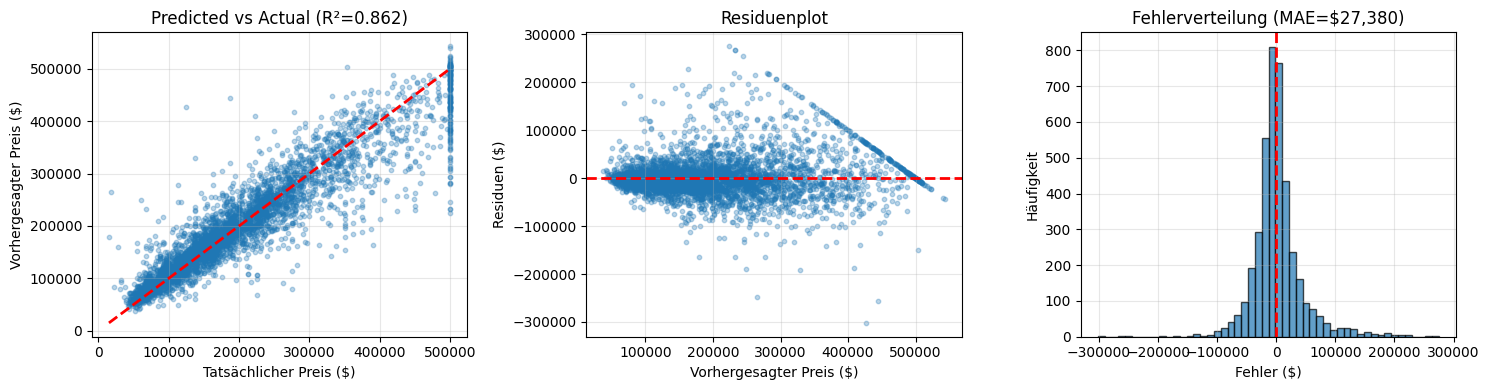

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Lade Original-Daten
housing = pd.read_csv("../housing.csv")
housing_v2 = prepare_data_v2(housing)

X_v2 = housing_v2.drop("median_house_value", axis=1)
y_v2 = housing_v2["median_house_value"]
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42)

# Vorhersagen
y_pred_v2 = model_v2.predict(X_test_v2)

# Metriken
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2, y_pred_v2))
mae_v2 = mean_absolute_error(y_test_v2, y_pred_v2)
r2_v2 = r2_score(y_test_v2, y_pred_v2)
mape_v2 = np.mean(np.abs((y_test_v2 - y_pred_v2) / y_test_v2)) * 100

print("=== MODELL V2 PERFORMANCE ===\n")
print(f"RMSE:  ${rmse_v2:>12,.2f}")
print(f"MAE:   ${mae_v2:>12,.2f}")
print(f"R²:    {r2_v2:>13.4f}")
print(f"MAPE:  {mape_v2:>12.2f}%")

# Visualisierung
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Predicted vs Actual
axes[0].scatter(y_test_v2, y_pred_v2, alpha=0.3, s=10)
axes[0].plot([y_test_v2.min(), y_test_v2.max()], [y_test_v2.min(), y_test_v2.max()], 'r--', lw=2)
axes[0].set_xlabel('Tatsächlicher Preis ($)')
axes[0].set_ylabel('Vorhergesagter Preis ($)')
axes[0].set_title(f'Predicted vs Actual (R²={r2_v2:.3f})')
axes[0].grid(True, alpha=0.3)

# Residuen
residuals = y_test_v2 - y_pred_v2
axes[1].scatter(y_pred_v2, residuals, alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Vorhergesagter Preis ($)')
axes[1].set_ylabel('Residuen ($)')
axes[1].set_title('Residuenplot')
axes[1].grid(True, alpha=0.3)

# Fehlerverteilung
axes[2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Fehler ($)')
axes[2].set_ylabel('Häufigkeit')
axes[2].set_title(f'Fehlerverteilung (MAE=${mae_v2:,.0f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interaktiver Test - Eigene Werte eingeben

In [11]:
# Definiere dein eigenes Haus
my_house = pd.DataFrame([{
    'longitude': -122.4,        # Ändere diese Werte!
    'latitude': 37.8,
    'housing_median_age': 30,
    'total_rooms': 2000,
    'total_bedrooms': 400,
    'population': 700,
    'households': 350,
    'median_income': 7.5,
    'ocean_proximity': 'NEAR BAY'  # NEAR BAY, NEAR OCEAN, INLAND, <1H OCEAN, ISLAND
}])

my_house_prepared = prepare_data_v2(my_house)
my_prediction = model_v2.predict(my_house_prepared)[0]

print("=== DEIN HAUS ===\n")
print(f"Vorhergesagter Preis: ${my_prediction:,.2f}")

=== DEIN HAUS ===

Vorhergesagter Preis: $429,679.31
